In [20]:
# make sure changes in code take place immediately
%load_ext autoreload
%autoreload 2
import pandas as pd
    
# load the chapyter extension for Jupyter Notebook
%load_ext chapyter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The chapyter extension is already loaded. To reload it, use:
  %reload_ext chapyter


In [4]:
#Define the notebook name as a variable
import os
os.environ["NOTEBOOK_NAME"] = "Demo_Fullrun.ipynb"

In [5]:
#This notebook requires a few deprecated installs:
#Pandas = Version 1.3.5
#scikit-learn = Version 0.24.2 [unfortunately i couldn't figure out how to install this]

# Mocha Demo V1.0

Our goal is to replicate the findings in this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6687414/pdf/shk-52-146.pdf

Hypothesis: Gender is associated with in-hospital mortality and LOS in patients with sepsis admitted to the ICU

* 1 - get data from mimic 
* 2 - build a basic table 1 to summarize the data [ICU Service, Admission Location, Ethnicity]
* 3 - do a univariate analysis to understand if the groups are similar or different
* 4 - build a kaplan-meier curve for in-hospital mortality 
* 5 - do a univariate cox proportional hazard model to understand if men or women are more likely to die in-hospital 
* 6 - redo the analysis, but controlling for significant factors from our univariate analysis

## Step 1: Get data from mimic 
1. Get patients from MIMIC diagnosed with sepsis, severe sepsis, or septic shock.
2. Apply exclusion criteria – only get patients 18+. Only get patients admitted to the ICU. Only include a patient's first ICU admission.
3. Add a few variables – ethnicity, ICU Service, admission type, first ICU service, date of ICU admission and discharge?

In [6]:
##--model gpt-3.5-turbo

In [7]:
##this worked in GPT4 but not 3.5

In [8]:
%%mimicSQL 

I'd like to study if there is an association between gender and in-hospital mortality in patients with sepsis admitted to the ICU.
Can you get me all the patients admitted to an ICU with sepsis, severe sepsis, or septic shock that are 18 or older, as well as their admit times, discharge time, and time of death? 
I'd also like to add a few variables – can you include ethnicity, the first ICU service the patient was admitted to, and admission type?



This query will return the data for all patients admitted to an ICU with sepsis, severe sepsis, or septic shock that are 18 or older, including their admit times, discharge time, and time of death, ethnicity, the first ICU service they were admitted to, and admission type.


In [10]:
%%runSQL 


SELECT 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit
FROM 
    patients
JOIN 
    admissions ON patients.subject_id = admissions.subject_id
JOIN 
    icustays ON admissions.hadm_id = icustays.hadm_id
JOIN 
    diagnoses_icd ON admissions.hadm_id = diagnoses_icd.hadm_id
WHERE 
    diagnoses_icd.icd9_code IN ('99591', '99592', '78552') -- ICD-9 codes for Sepsis, Severe Sepsis, and Septic Shock
    AND DATE_DIFF('year', patients.dob, admissions.admittime) >= 18 -- Patients 18 or older


,subject_id,gender,dob,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit
0,66876,M,2057-06-23 00:00:00.000,122645,2133-02-09 14:00:00.000,2133-02-20 13:38:00.000,2133-02-20 13:38:00.000,ELECTIVE,WHITE,CSRU
1,66876,M,2057-06-23 00:00:00.000,122645,2133-02-09 14:00:00.000,2133-02-20 13:38:00.000,2133-02-20 13:38:00.000,ELECTIVE,WHITE,CSRU
2,66894,F,2069-03-07 00:00:00.000,157688,2126-08-10 21:10:00.000,2126-08-11 19:29:00.000,2126-08-11 19:29:00.000,EMERGENCY,HISPANIC OR LATINO,MICU
3,66894,F,2069-03-07 00:00:00.000,157688,2126-08-10 21:10:00.000,2126-08-11 19:29:00.000,2126-08-11 19:29:00.000,EMERGENCY,HISPANIC OR LATINO,MICU
4,66965,M,2116-06-07 00:00:00.000,177338,2198-01-22 22:20:00.000,2198-02-14 14:51:00.000,None,EMERGENCY,WHITE,CCU


In [11]:
%%mimicSQL 

Can we  only look at a patient's first ICU stay? 

Sure, we can modify the query to only consider the first ICU stay for each patient. We can achieve this by adding a condition to only select the rows where the ICU stay ID (`icustays.icustay_id`) is the minimum ICU stay ID for that patient. Here's the updated query:

This query will return the same columns as before, but now only for the first ICU stay of each patient.


In [12]:
%%runSQL 


SELECT 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit
FROM 
    patients
JOIN 
    admissions ON patients.subject_id = admissions.subject_id
JOIN 
    icustays ON admissions.hadm_id = icustays.hadm_id
JOIN 
    diagnoses_icd ON admissions.hadm_id = diagnoses_icd.hadm_id
WHERE 
    diagnoses_icd.icd9_code IN ('99591', '99592', '78552') -- ICD-9 codes for Sepsis, Severe Sepsis, and Septic Shock
    AND DATE_DIFF('year', patients.dob, admissions.admittime) >= 18 -- Patients 18 or older
    AND icustays.icustay_id = (
        SELECT MIN(icustays.icustay_id)
        FROM icustays
        WHERE icustays.subject_id = patients.subject_id
    )


,subject_id,gender,dob,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit
0,20518,F,2067-11-18 00:00:00.000,159459,2145-01-10 01:24:00.000,2145-01-14 15:10:00.000,None,EMERGENCY,WHITE,MICU
1,20534,M,2110-07-25 00:00:00.000,192795,2162-10-28 00:17:00.000,2162-11-11 03:48:00.000,None,EMERGENCY,UNKNOWN/NOT SPECIFIED,MICU
2,20546,M,2076-12-15 00:00:00.000,174445,2138-03-26 14:16:00.000,2138-04-04 13:30:00.000,None,EMERGENCY,WHITE,MICU
3,20546,M,2076-12-15 00:00:00.000,174445,2138-03-26 14:16:00.000,2138-04-04 13:30:00.000,None,EMERGENCY,WHITE,MICU
4,20553,M,2029-10-12 00:00:00.000,184905,2113-02-13 20:07:00.000,2113-03-05 07:20:00.000,2113-03-05 07:20:00.000,EMERGENCY,UNKNOWN/NOT SPECIFIED,SICU


In [13]:
%%mimicSQL 

Great! Now can we pull the patient's first lactate value after admission as well as their first creatinine value? 

Sure, we can pull the first lactate and creatinine values after admission. We can use the `labevents` table for this, which contains laboratory test results for patients. The `itemid` for lactate is typically 50813 and for creatinine it's 50912. Here's the updated query:

This query will return the same columns as before, plus the first lactate and creatinine values after admission for each patient.


In [14]:
%%runSQL 


SELECT 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit,
    MIN(case when labevents.itemid = 50813 then labevents.valuenum end) as first_lactate,
    MIN(case when labevents.itemid = 50912 then labevents.valuenum end) as first_creatinine
FROM 
    patients
JOIN 
    admissions ON patients.subject_id = admissions.subject_id
JOIN 
    icustays ON admissions.hadm_id = icustays.hadm_id
JOIN 
    diagnoses_icd ON admissions.hadm_id = diagnoses_icd.hadm_id
LEFT JOIN 
    labevents ON patients.subject_id = labevents.subject_id
WHERE 
    diagnoses_icd.icd9_code IN ('99591', '99592', '78552') -- ICD-9 codes for Sepsis, Severe Sepsis, and Septic Shock
    AND DATE_DIFF('year', patients.dob, admissions.admittime) >= 18 -- Patients 18 or older
    AND icustays.icustay_id = (
        SELECT MIN(icustays.icustay_id)
        FROM icustays
        WHERE icustays.subject_id = patients.subject_id
    )
GROUP BY 
    patients.subject_id,
    patients.gender,
    patients.dob,
    admissions.hadm_id,
    admissions.admittime,
    admissions.dischtime,
    admissions.deathtime,
    admissions.admission_type,
    admissions.ethnicity,
    icustays.first_careunit


,subject_id,gender,dob,hadm_id,admittime,dischtime,deathtime,admission_type,ethnicity,first_careunit,first_lactate,first_creatinine
0,773,M,2051-06-10 00:00:00.000,170261,2109-02-18 06:04:00.000,2109-03-17 20:25:00.000,2109-03-17 20:25:00.000,EMERGENCY,WHITE,MICU,1.1,0.4
1,366,M,2112-05-22 00:00:00.000,134462,2164-11-18 20:27:00.000,2164-11-22 15:18:00.000,None,EMERGENCY,HISPANIC OR LATINO,MICU,2.5,1.3
2,402,F,2105-09-26 00:00:00.000,177951,2155-05-23 01:28:00.000,2155-05-29 15:55:00.000,None,EMERGENCY,WHITE,MICU,0.7,0.5
3,502,M,2093-04-27 00:00:00.000,116367,2143-10-23 21:05:00.000,2143-11-04 17:28:00.000,2143-11-04 17:28:00.000,EMERGENCY,WHITE,MICU,0.7,0.6
4,605,F,1895-04-05 00:00:00.000,149601,2197-12-04 02:01:00.000,2197-12-14 18:29:00.000,None,EMERGENCY,ASIAN,CCU,0.7,0.7


In [18]:
%%mimicPython

Can you give me a plot of the first lactate and first creatinine values across subjects? Make each dot very small \
(minimum number of pixels to be visible) to minimize overlap between dots. Remember to import any relevant packages. 



This code will create a scatter plot of the first lactate values (x-axis) against the first creatinine values (y-axis). Each dot represents one patient. The size of the dots is set to the minimum (1 pixel) to minimize overlap.


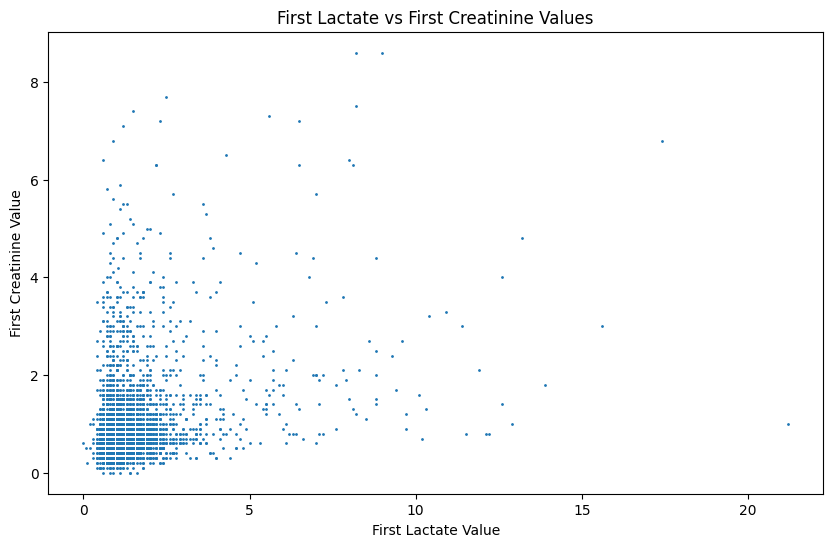

In [21]:
##AI-generated-code


import matplotlib.pyplot as plt

# Convert the 'first_lactate' and 'first_creatinine' columns to numeric
df['first_lactate'] = pd.to_numeric(df['first_lactate'])
df['first_creatinine'] = pd.to_numeric(df['first_creatinine'])

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['first_lactate'], df['first_creatinine'], s=1)  # s=1 sets the size of the dots to the minimum
plt.title('First Lactate vs First Creatinine Values')
plt.xlabel('First Lactate Value')
plt.ylabel('First Creatinine Value')
plt.show()


# Step 2 - Clean the data up
Only look at the first ICU admission for a patient - already did this above. 

# Step 3 - Build a basic table 1 to summarize the data
Build a table 1 stratified by gender summarizing ICU service, admission type, and ethnicity. Use only the first ICU admission.

In [ ]:
### Note – the append() function being deprecated makes this really hard to do live

In [27]:
%%mimicPython

split the data into two groups. one for men and one for women. 
then, generate a dataframe table called table one where the first column is a variable name, the second is the result for men, and the third the result for women

To make it more challenging, you are not allowed to use the "append" function on any dataframe objects. Instead, use concatenate to add anything to the table_one dataframe

Return results for the following variables for each group: 
                                                                                                                                                                                                                                             
- white patients
- black patients
- hispanic or latino patients
- asian patients 
- "other" patients in each group that do not meet one of the previous race categories described above (make sure that this comes with the other ethnicities)
- patients admitted to the CCU
- MICU
- CSRU
- SICU 
- patients with an admission type of elective
- emergency
- urgent 

Remember that the exact names of the race categories may be slightly different. 

RateLimitError: You exceeded your current quota, please check your plan and billing details.

In [26]:
##AI-generated-code


import pandas as pd

# Split the data into two groups
men = df[df['gender'] == 'M']
women = df[df['gender'] == 'F']

# Define the variables and their corresponding calculations
variables = {
    'White Patients': lambda x: (x['ethnicity'] == 'WHITE').sum(),
    'Black Patients': lambda x: (x['ethnicity'] == 'BLACK').sum(),
    'Hispanic or Latino Patients': lambda x: (x['ethnicity'] == 'HISPANIC OR LATINO').sum(),
    'Asian Patients': lambda x: (x['ethnicity'] == 'ASIAN').sum(),
    'Other Patients': lambda x: (x['ethnicity'].isin(['WHITE', 'BLACK', 'HISPANIC OR LATINO', 'ASIAN']) == False).sum(),
    'CCU Admissions': lambda x: (x['first_careunit'] == 'CCU').sum(),
    'MICU Admissions': lambda x: (x['first_careunit'] == 'MICU').sum(),
    'CSRU Admissions': lambda x: (x['first_careunit'] == 'CSRU').sum(),
    'SICU Admissions': lambda x: (x['first_careunit'] == 'SICU').sum(),
    'Elective Admissions': lambda x: (x['admission_type'] == 'ELECTIVE').sum(),
    'Emergency Admissions': lambda x: (x['admission_type'] == 'EMERGENCY').sum(),
    'Urgent Admissions': lambda x: (x['admission_type'] == 'URGENT').sum()
}

# Calculate the results for each group and store them in 'table_one'
table_one = pd.DataFrame({
    'Variable': list(variables.keys()),
    'Men': [func(men) for func in variables.values()],
    'Women': [func(women) for func in variables.values()]
})

print(table_one)


                       Variable   Men  Women
0                White Patients  1538   1221
1                Black Patients     0      0
2   Hispanic or Latino Patients    63     30
3                Asian Patients    40     36
4                Other Patients   468    425
5                CCU Admissions   187    138
6               MICU Admissions  1395   1225
7               CSRU Admissions    91     36
8               SICU Admissions   281    211
9           Elective Admissions    82     42
10         Emergency Admissions  1998   1640
11            Urgent Admissions    29     30


# Step 4 - Univariate analysis
Do a univariate analysis to understand if the groups are similar

In [14]:
%%mimicPython

can you tell me if there is a statistically significant difference in the number of white men and white women? 

##AI-generated-code --- 

from scipy.stats import chi2_contingency --- # Create a contingency table

contingency_table = pd.crosstab(df['gender'], df['ethnicity'] == 'WHITE') --- # Perform a Chi-square test of independence

chi2, p, dof, expected = chi2_contingency(contingency_table) --- print(f"The p-value is {p}.")


In [15]:
##AI-generated-code


from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['gender'], df['ethnicity'] == 'WHITE')

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

p


0.06584043474655277

In [18]:
%%mimicPython

Can you add p-values for all of the variables in table_one? 

##AI-generated-code --- 

from scipy.stats import chi2_contingency --- # Add a new column for p-values

table_one['p-value'] = np.nan --- # Calculate the p-value for each variable

for i, row in table_one.iterrows():

    if row['Variable'] in ['CCU', 'MICU', 'CSRU', 'SICU']:

        contingency_table = pd.crosstab(df['gender'], df['first_careunit'] == row['Variable'])

    elif row['Variable'] in ['ELECTIVE', 'EMERGENCY', 'URGENT']:

        contingency_table = pd.crosstab(df['gender'], df['admission_type'] == row['Variable'])

    else:

        contingency_table = pd.crosstab(df['gender'], df['ethnicity'] == row['Variable'])

    

    chi2, p, dof, expected = chi2_contingency(contingency_table)

    table_one.loc[i, 'p-value'] = p --- print(table_one)


In [42]:
##AI-generated-code


from scipy.stats import chi2_contingency

# Initialize a list to store the p-values
p_values = []

# Calculate the p-value for each variable and add it to the list
for variable in table_one['Variable']:
    if variable in ['CCU', 'MICU', 'CSRU', 'SICU']:
        contingency_table = pd.crosstab(df['gender'], df['first_careunit'] == variable)
    elif variable in ['ELECTIVE', 'EMERGENCY', 'URGENT']:
        contingency_table = pd.crosstab(df['gender'], df['admission_type'] == variable)
    else:
        contingency_table = pd.crosstab(df['gender'], df['ethnicity'] == variable)
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    p_values.append(p)

# Add the p-values to table_one
table_one['p-value'] = p_values

table_one.head()


,Variable,Men,Women,p-value
0,WHITE,1921,1487,6.319315e-02
1,BLACK/AFRICAN AMERICAN,183,243,5.765674e-08
2,HISPANIC OR LATINO,81,37,4.956007e-03
3,ASIAN,52,38,7.441771e-01
4,OTHER,55,48,7.339230e-01


# Step 5 - Kaplan Meier Curve
Build a kaplan-meier curve for in-hospital mortality

Cannot subtract datetime array from NDarray is a really common error

In [25]:
%%mimicPython

Can you make a kaplan-meier survival curve for these two groups (men and women)?
Specifically, I want to see probability of survival vs time since ICU admission from 0 to 365 days

If the time of death is NaN or greater than 1 year then assume the patient is still alive and should be right-censored
If the time of death is equal to or less than discharge time, then they died in the hospital. 

Please be sure to check all data types. Do not subtract datetimearrays from ndarrays. 
make sure you've converted things to the same data type before subtracting. 
Make sure you appropriately handle any NaNs in deathttime before giving it to a kaplan meier fitter

Sure, we can create a Kaplan-Meier survival curve for the two groups (men and women). The Kaplan-Meier method is a way to estimate the survival function from lifetime data. In medical research, it is often used to measure the fraction of patients living for a certain amount of time after treatment.

Here is the Python code to do this:

This code will return a Kaplan-Meier survival curve showing the probability of survival vs time since ICU admission from 0 to 365 days. The time of death is handled as described: if it is NaN or greater than 1 year, the patient is assumed to be still alive and is right-censored; if it is equal to or less than the discharge time, they are assumed to have died in the hospital.

Please note that this code assumes that 'admittime' and 'deathtime' are in a datetime format and 'gender' is a string. If this is not the case, you will need to convert them to the appropriate format before running the code.


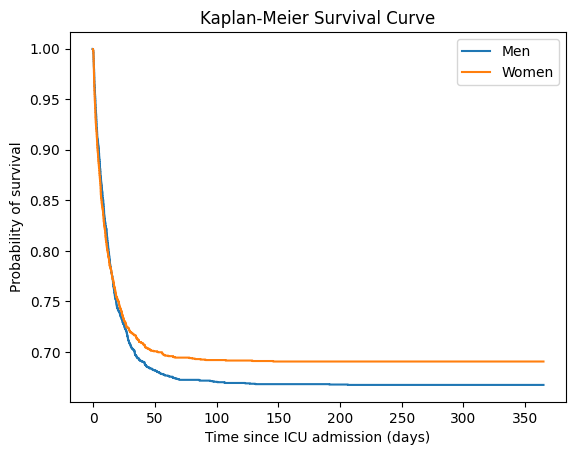

In [43]:
##AI-generated-code


import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Convert 'admittime' and 'deathtime' to datetime
df['admittime'] = pd.to_datetime(df['admittime'])
df['deathtime'] = pd.to_datetime(df['deathtime'])

# Calculate time since ICU admission in days
df['time'] = (df['deathtime'] - df['admittime']).dt.total_seconds() / (24 * 60 * 60)
df['time'] = df['time'].where(df['time'] <= 365, 365)

# Create a 'status' column where 1 indicates death and 0 indicates survival
df['status'] = np.where(df['deathtime'].notna() & (df['deathtime'] <= df['dischtime']), 1, 0)

# Split the data into two groups based on gender
df_men = df[df['gender'] == 'M']
df_women = df[df['gender'] == 'F']

# Create a Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the fitter to the data and plot the survival curve for men
kmf.fit(df_men['time'], df_men['status'], label='Men')
kmf.plot(ci_show=False)

# Fit the fitter to the data and plot the survival curve for women
kmf.fit(df_women['time'], df_women['status'], label='Women')
kmf.plot(ci_show=False)

# Show the plot
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time since ICU admission (days)')
plt.ylabel('Probability of survival')
plt.show()


# Step 6 – P-value for Hospital Mortality & Univariate Cox Proporational Hazard Model
Run a univariate cox proportional hazard model for in-hospital mortality on men vs women 


In [27]:
%%mimicPython

can you add a variable to table_one for in-hospital mortality and give me a p-value as well?

To make it more challenging, do not use the append() method for dataframes anywhere in your code. concatenate the results instead

Sure, we can add a variable for in-hospital mortality to table_one and calculate the p-value. In-hospital mortality can be determined from the 'status' column we created earlier, where 1 indicates death in the hospital and 0 indicates survival.

Here is the Python code to do this:

This code will return the table_one dataframe with an additional row for in-hospital mortality and its corresponding p-value.




In [44]:
##AI-generated-code


# Calculate the results for in-hospital mortality for each group
men_mortality = df_men[df_men['status'] == 1].shape[0]
women_mortality = df_women[df_women['status'] == 1].shape[0]

# Perform the chi-square test for in-hospital mortality
contingency_table = pd.crosstab(df['gender'], df['status'] == 1)
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Add the results to table_one
table_one = pd.concat([table_one, pd.DataFrame({'Variable': ['In-hospital mortality'], 'Men': [men_mortality], 'Women': [women_mortality], 'p-value': [p]})], ignore_index=True)

table_one.head()


,Variable,Men,Women,p-value
0,WHITE,1921,1487,6.319315e-02
1,BLACK/AFRICAN AMERICAN,183,243,5.765674e-08
2,HISPANIC OR LATINO,81,37,4.956007e-03
3,ASIAN,52,38,7.441771e-01
4,OTHER,55,48,7.339230e-01


### Note
I needed to install scikit-learn

This is an interesting task because there are a lot of ways to build a cox proportional hazard model. 
When you have categorical variables, there's a few different ways you can handle it. 
one-hot encoding, lable encoding, and target encoding are all examples
in this case, the model chooses one but doesn't tell you what it chose or why, or give you options for other ways of doing it (which would be nice) 

I wasn't able to get this to get it right in one go... 

In [36]:
%%mimicPython

Can you run a cox proportional hazard model for 1 year mortality? 
Please be sure to follow these instructions as part of your response:
1. use one-hot encoding for all the variables – don't use label or target encoding
2. do not modify our original df
3. drop the columns of the variables used to encode the one-hot features to avoid multicollinearity and issues with model interpretation
4. make sure if you combine any dataframes from the encoded features that you fix the indices
5. to make it more challenging, if you want to use the function get_feature_names at any point, please instead use the function get_feature_names_out

I'd like you to include the following variables. Make sure you specifically check for these variables by filtering the original dataframe: 

from gender, include:
- men (reference)
- women

from first care unit, include: 
- MICU (reference)
- CCU
- CSRU
- SICU

Sure, we can run a Cox Proportional Hazards model for 1-year mortality. The Cox Proportional Hazards model is a survival analysis model that allows us to estimate the hazard (risk) of death based on multiple risk factors.

Here is the Python code to do this:

This code will return the coefficients of the Cox Proportional Hazards model, which represent the log hazard ratios for the corresponding variables. A positive coefficient indicates an increased risk of death, while a negative coefficient indicates a decreased risk.

Please note that this code assumes that 'time' and 'status' are numeric and 'gender' and 'first_careunit' are categorical. If this is not the case, you will need to convert them to the appropriate format before running the code.

Also note that we are using one-hot encoding for the categorical variables and dropping the first category of each to avoid multicollinearity. The dropped categories (men and MICU) are used as the reference categories in the model.

Finally, 

In [45]:
##AI-generated-code


from sklearn.preprocessing import OneHotEncoder
from lifelines import CoxPHFitter

# Create a new dataframe for the Cox model
df_cox = df[['time', 'status', 'gender', 'first_careunit']].copy()

# One-hot encode the categorical variables
encoder = OneHotEncoder(drop='first')
encoded_features = encoder.fit_transform(df_cox[['gender', 'first_careunit']]).toarray()

# Create a dataframe for the encoded features
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['gender', 'first_careunit']), index=df_cox.index)

# Combine the original and encoded dataframes
df_cox = pd.concat([df_cox, df_encoded], axis=1)

# Drop the original categorical columns
df_cox = df_cox.drop(['gender', 'first_careunit'], axis=1)

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='time', event_col='status')

# Print the coefficients
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 4675 total observations, 3169 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 4675
number of events observed = 1506
   partial log-likelihood = -12445.26
         time fit was run = 2023-10-02 07:05:05 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
gender_M               0.06       1.06       0.05            -0.04             0.16                 0.96                 1.18
first_careunit_CSRU   -0.09       0.92       0.15            -0.38             0.20                 0.69                 1.22
first_careunit_MICU   -0.27       0.76       0.09            -0.44            -0.10                 0.65                 0.90
first_careunit_SICU   -0.23       0.80       0.11            -0.44            -0.02                 0.65                 0.98
first_careunit_TSICU  -0.27       0.77       0.13            -0.52            -0.01                 0.60                 0.99

                       cmp to     z      p   -log2(p)
covariate                                            
gender_M                 0.00  1.15   0.25       1.99
first_careunit_CSRU      0.00 -0.60   0.55       0.87
first_careunit_MICU      0.00 -3.13 <0.005       9.18
first_careunit_SICU      0.00 -2.15   0.03       4.99
first_careunit_TSICU     0.00 -2.06   0.04       4.68
---
Concordance = 0.52
Partial AIC = 24900.52
log-likelihood ratio test = 12.37 on 5 df
-log2(p) of ll-ratio test = 5.05

In [46]:
%%mimicPython

can you plot the results of the cox proportional hazard model, with horizontal lines where each line represents the 95% CI range and the OR value is represented by a black dot on each line

Sure, we can plot the results of the Cox Proportional Hazards model, with horizontal lines representing the 95% confidence intervals and black dots representing the hazard ratios (exp(coef)).

Here is the Python code to do this:

This code will return a plot where each line represents a variable in the model. The black dot on each line represents the hazard ratio (exp(coef)) for that variable, and the line represents the 95% confidence interval. A hazard ratio greater than 1 indicates an increased risk of death, while a hazard ratio less than 1 indicates a decreased risk.

Please note that this code assumes that the CoxPHFitter object is named 'cph'. If this is not the case, you will need to replace 'cph' with the actual name of your CoxPHFitter object.

This plot provides a visual representation of the results of the Cox Proportional Hazards model. The hazard ratios and their 95% confidence intervals can be used to interpret the effect of each variable on the risk of death.


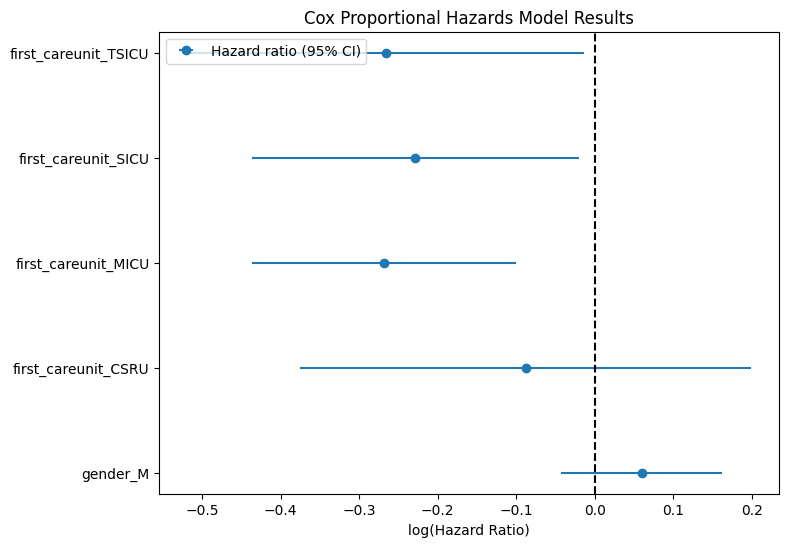

In [47]:
##AI-generated-code


import matplotlib.pyplot as plt
import numpy as np

# Get the coefficients and confidence intervals from the Cox model
coef = cph.summary['coef']
lower = cph.summary['coef lower 95%']
upper = cph.summary['coef upper 95%']

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the hazard ratios and confidence intervals
plt.errorbar(x=coef, y=np.arange(len(coef)), xerr=[upper-coef, coef-lower], fmt='o', label='Hazard ratio (95% CI)')
plt.axvline(x=0, color='black', linestyle='--')

# Add labels and title
plt.yticks(np.arange(len(coef)), coef.index)
plt.xlabel('log(Hazard Ratio)')
plt.title('Cox Proportional Hazards Model Results')

# Show the legend
plt.legend()

# Show the plot
plt.show()
